In [3]:
import requests
from bs4 import BeautifulSoup
import os


In [4]:
url = 'https://nanohub.org/citations' #url we want to pull the images from and save under plots_production  
doc = requests.get(url) # beautiful soup can't work with http requests directly so must get document behind the link and feed that to beautiful soup 
citationPage = BeautifulSoup(doc.text, 'html')
images = citationPage.find_all('img') # extract all the image tags

# lists to extract appropirate info
imageLinks = []
imageDesc = []
csvFiles = []
for link in citationPage.find_all('a'):
    potentialcsv = link.get('href')
    if potentialcsv is not None and potentialcsv.endswith('.csv'):
        csvFiles.append("http://nanohub.org" + potentialcsv)
print(csvFiles)
for files in csvFiles:
    download = requests.get(files)
    names = files.split('/')
    with open(names[-1], 'wb') as f:
        f.write(download.content)
        os.rename(names[-1], './pulledcsv/' + names[-1]) # saves all web scraped csv files to a pulled csv folder 
imageLinks = [image['src'] for image in images] # extract the links to all the images we want to save
imageDesc = [image['alt'] for image in images] #extract any description associated with the images so we can have an easier time naming 
imageLinks = ["http://nanohub.org" + image for image in imageLinks] #append nanohub.org to get the actual not just the partial link 
imgCount = 0 # used for naming which citation image is saved 
for toSave in imageLinks:
    with open('Citationimg' + str(imgCount) + '.svg', 'wb') as f:
        filename = 'Citationimg' + str(imgCount) + '.svg'
        citationimg = requests.get(toSave)
        f.write(citationimg.content) # .content gets the individual byte information and saves that 
        os.rename(filename, './plots_production/' + filename) # moves the files to the appropriate place 
    imgCount += 1


['http://nanohub.org/app/site/stats/citation_maps/citations_report.csv']


In [5]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.ticker as tck

In [6]:
rawCitation = []
reachedSeven = False
reachedSix = False
cumulative = pd.DataFrame()
with open('./pulledcsv/citations_report.csv', 'r') as csvfile:
    citationData = csv.reader(csvfile)
    
    for line in citationData:
        if len(line) == 0:
            continue
        if line[0] == 'Table 6: Citations per year':
            rawCitation.append(line)
            reachedSix = True
            continue
        if line[0] == 'Table 7: Citations by type':
            reachedSeven = True
        if reachedSeven == False and reachedSix == True:
            rawCitation.append(line)
rawCitation.pop(0) #get rid of the unnecessary title
header = rawCitation.pop(0) # keep the header becuase must flip the list of lists 
tail = rawCitation.pop(-1) # keep the tail 
rawCitation = rawCitation[::-1]
rawCitation.insert(0, header)
rawCitation.append(tail)
rawCitation = pd.DataFrame(rawCitation) #rawCitation is now a pandas dataframe 
#print(rawCitation)
rowNum = rawCitation.shape[0]
cumulative = rawCitation.copy(deep=True)

for i in range(2, rowNum - 1):
    cumulative.at[i, 1] = int(cumulative.at[i - 1, 1]) + int(cumulative.at[i, 1])
    cumulative.at[i, 2] = int(cumulative.at[i - 1, 2]) + int(cumulative.at[i, 2])
    cumulative.at[i, 3] = int(cumulative.at[i - 1, 3]) + int(cumulative.at[i, 3])


cumulative.reset_index(drop=True, inplace=True)
print(cumulative)
years = list(rawCitation.iloc[:, 0]) # x-axis for the bar graphs shown below 
rawNCN = list(rawCitation.iloc[:, 1])
rawNCN.pop(0)
rawNCN.pop()
rawONCN = list(rawCitation.iloc[:,2])
rawONCN.pop(0)
rawONCN.pop()
rawTot = list(rawCitation.iloc[:,3])
rawTot.pop(0)
rawTot.pop()
cumuNCN = list(cumulative.iloc[:,1])
cumuNCN.pop(0)
cumuNCN.pop()
cumuONCN = list(cumulative.iloc[:,2])
cumuONCN.pop(0)
cumuONCN.pop()
cumuTot = list(cumulative.iloc[:,3])
cumuTot.pop(0)
cumuTot.pop()

years.pop(0)
years.pop()
print(years)
print(rawNCN)
print(rawONCN)
print(cumuNCN)
print(cumuONCN)
print(cumuTot)



    
            

        0                1             2       3
0    Year   NCN Affiliated   Outside NCN   Total
1    2000                0             1       1
2    2001                2             6       8
3    2002                9            15      24
4    2003               17            28      45
5    2004               28            46      74
6    2005               51            77     128
7    2006               70           117     187
8    2007              114           171     285
9    2008              160           216     376
10   2009              219           318     537
11   2010              267           397     664
12   2011              342           509     851
13   2012              380           640    1020
14   2013              437           795    1232
15   2014              486           919    1405
16   2015              578          1040    1618
17   2016              643          1210    1853
18   2017              693          1366    2059
19   2018           

21
21
        0                1             2       3
0    Year   NCN Affiliated   Outside NCN   Total
1    2000                0             1       1
2    2001                2             5       7
3    2002                7             9      16
4    2003                8            13      21
5    2004               11            18      29
6    2005               23            31      54
7    2006               19            40      59
8    2007               44            54      98
9    2008               46            45      91
10   2009               59           102     161
11   2010               48            79     127
12   2011               75           112     187
13   2012               38           131     169
14   2013               57           155     212
15   2014               49           124     173
16   2015               92           121     213
17   2016               65           170     235
18   2017               50           156     206
19   2018     

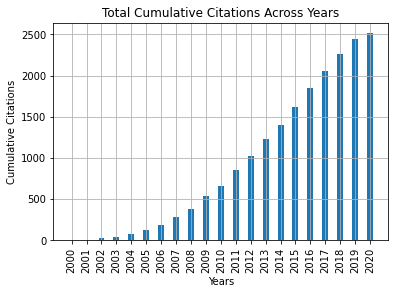

In [10]:
print(len(years))
print(len(cumuTot))
cumuTot = [float(el) for el in cumuTot]
print(rawCitation)
plt.figure()
ypos = np.arange(len(years))
plt.xticks(ypos, years, rotation = 90)
plt.bar(ypos, cumuTot, label = "Cumulative total", width = 0.4)
plt.xlabel("Years")
plt.ylabel("Cumulative Citations")
plt.title("Total Cumulative Citations Across Years")
plt.grid()
plt.savefig("./plots_production/totalCumulativeCitations.jpg")

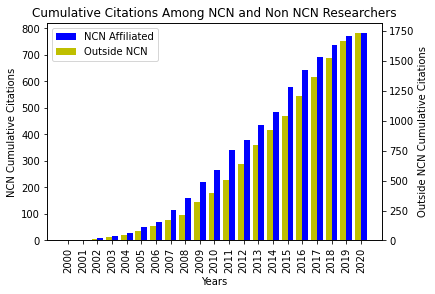

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xticks(ypos, years, rotation=90)
ax2 = ax.twinx()
cumuNCN = [float(i) for i in cumuNCN]
cumuONCN = [float(i) for i in cumuONCN]
first =ax.bar(ypos + 0.2, cumuNCN, width=0.4, color='b', align='center')
second =ax2.bar(ypos - 0.2, cumuONCN, width=0.4,color='y',align='center')
plt.legend([first, second],['NCN Affiliated', 'Outside NCN'])
plt.title("Cumulative Citations Among NCN and Non NCN Researchers")
ax.set_xlabel("Years")
ax.set_ylabel("NCN Cumulative Citations")
ax2.set_ylabel("Outside NCN Cumulative Citations")
plt.savefig("./plots_production/cumulativeMultAxes.jpg")

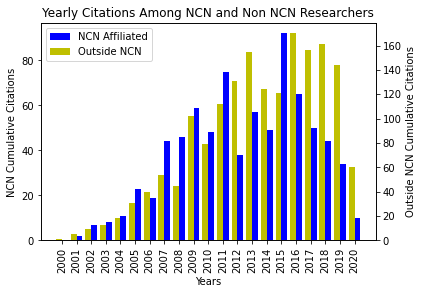

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xticks(ypos, years, rotation=90)
ax2 = ax.twinx()
rawNCN = [float(i) for i in rawNCN]
rawONCN = [float(i) for i in rawONCN]
first =ax.bar(ypos + 0.2, rawNCN, width=0.4, color='b', align='center')
second =ax2.bar(ypos - 0.2, rawONCN, width=0.4,color='y',align='center')
plt.legend([first, second],['NCN Affiliated', 'Outside NCN'])
plt.title("Yearly Citations Among NCN and Non NCN Researchers")
ax.set_xlabel("Years")
ax.set_ylabel("NCN Cumulative Citations")
ax2.set_ylabel("Outside NCN Cumulative Citations")
plt.savefig("./plots_production/yearlyMultAxes.jpg")

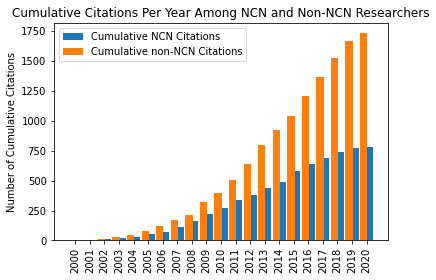

In [13]:
plt.xticks(ypos, years, rotation = 90)
plt.ylabel("Number of Cumulative Citations")
plt.title("Cumulative Citations Per Year Among NCN and Non-NCN Researchers")
plt.bar(ypos + 0.2, cumuNCN, label = "Cumulative NCN Citations", width = 0.5)
plt.bar(ypos - 0.2, cumuONCN, label = "Cumulative non-NCN Citations", width = 0.5)
plt.legend()
plt.savefig("./plots_production/cumulativeSideBySide.jpg")

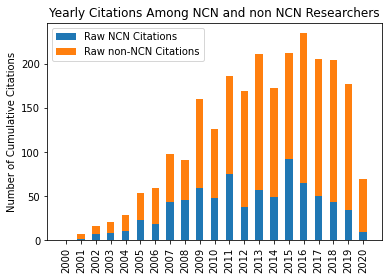

In [14]:
plt.xticks(ypos, years, rotation = 90)
plt.ylabel("Number of Cumulative Citations")
plt.title("Yearly Citations Among NCN and non NCN Researchers")
plt.bar(ypos, rawNCN, label = "Raw NCN Citations", width = 0.5)
plt.bar(ypos, rawONCN, label = "Raw non-NCN Citations", width = 0.5, bottom=rawNCN)
plt.legend()
plt.savefig("./plots_production/yearlyStacked.jpg")

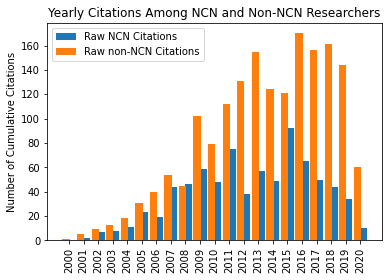

In [15]:
plt.xticks(ypos, years, rotation = 90)
plt.ylabel("Number of Cumulative Citations")
plt.title("Yearly Citations Among NCN and Non-NCN Researchers")
plt.bar(ypos + 0.2, rawNCN, label = "Raw NCN Citations", width = 0.5)
plt.bar(ypos - 0.2, rawONCN, label = "Raw non-NCN Citations", width = 0.5)
plt.legend()
plt.savefig("./plots_production/yearlySideBySide.jpg")

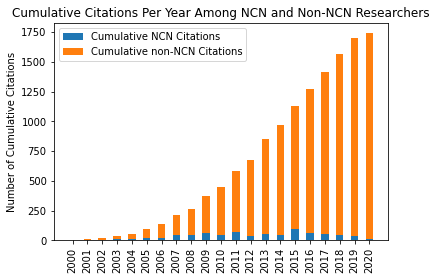

In [16]:
plt.xticks(ypos, years, rotation = 90)
plt.ylabel("Number of Cumulative Citations")
plt.title("Cumulative Citations Per Year Among NCN and Non-NCN Researchers")
plt.bar(ypos, cumuNCN, label = "Cumulative NCN Citations", width = 0.5)
plt.bar(ypos, cumuONCN, label = "Cumulative non-NCN Citations", width = 0.5, bottom=rawNCN)
plt.legend()
plt.savefig("./plots_production/cumulativeStacked.jpg")